In [1]:
from typing import Dict, Tuple, List, Any
from skimage import io
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from keras.callbacks import History
from tensorflow.keras import models, optimizers, losses, activations, callbacks, initializers, regularizers
from tensorflow.keras.layers import *
import tensorflow.keras.backend as backend
import tensorflow as tf

# Loading Data
def load_data_2(data_dir: str) -> Tuple[Dict[str, Dict[int, np.ndarray]], np.ndarray]:  # Tuple[np.ndarray, np.ndarray]
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images_for_dict = []
    label_2_images = {}
    directory_counter = 0
    for i,d in enumerate(directories):
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir)
                      if f.endswith(".jpg")]
        file_2_image = {}
        file_counter = 1
        for f in file_names:
            image = io.imread(f)
            file_2_image[file_counter] = image
            images_for_dict.append(image)
            labels.append(i)
            file_counter += 1
        label_2_images[d] = file_2_image
        images_for_dict = []
    return label_2_images, np.array(labels)

In [2]:
def prepare_x_y_according_to_description(label_2_images: Dict[str, Dict[int, np.ndarray]], file: str) -> Tuple[List[np.ndarray], np.ndarray]:
    samples_1_test = list()
    samples_2_test = list()
    labels_test = list()
    with open(file, 'r+') as f:
        train_lines = f.readlines()
        num_of_samples = int(train_lines[0].strip())
        for index in range(1, num_of_samples + 1, 1):
            line = train_lines[index]
            words = line.split()
            image1 = label_2_images[words[0]][int(words[1])]
            image2 = label_2_images[words[0]][int(words[2])]
            samples_1_test.append(image1.reshape(250**2) / 255)  
            samples_2_test.append(image2.reshape(250**2) / 255)
            labels_test.append(1)
        for index in range(num_of_samples + 1, 2 * num_of_samples + 1, 1):
            line = train_lines[index]
            words = line.split()
            image1 = label_2_images[words[0]][int(words[1])]
            image2 = label_2_images[words[2]][int(words[3])]
            samples_1_test.append(image1.reshape(250**2) / 255)  
            samples_2_test.append(image2.reshape(250**2) / 255)
            labels_test.append(0)

    p = np.random.permutation(2*num_of_samples)
    return [np.array(samples_1_test)[p], np.array(samples_2_test)[p]], np.array(labels_test)[p]

In [3]:
class OneShotModel(object):

    def __init__(self):
        self.__dim = 250
        input_shape = (self.__dim ** 2,)
        convolution_shape = (self.__dim, self.__dim, 1)
        seq_conv_model = [

            Reshape(input_shape=input_shape, target_shape=convolution_shape),
            Conv2D(32, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal()),#, kernel_regularizer=regularizers.l2(0)),
            Conv2D(32, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal()),#, kernel_regularizer=regularizers.l2(0)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Conv2D(64, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="valid", kernel_initializer=initializers.glorot_normal()),#, kernel_regularizer=regularizers.l2(1e-7)),
            Conv2D(64, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="valid", kernel_initializer=initializers.glorot_normal()),#, kernel_regularizer=regularizers.l2(1e-6)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Conv2D(128, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="valid", kernel_initializer=initializers.glorot_normal()),#, kernel_regularizer=regularizers.l2(1e-5)),
            Conv2D(128, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="valid", kernel_initializer=initializers.glorot_normal()),#, kernel_regularizer=regularizers.l2(1e-4)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Conv2D(256, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="valid", kernel_initializer=initializers.RandomNormal(stddev=0.01)),#, kernel_regularizer=regularizers.l2(1e-3)),
            Conv2D(256, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="valid", kernel_initializer=initializers.RandomNormal(stddev=0.01)),#, kernel_regularizer=regularizers.l2(1e-2)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Conv2D(512, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="valid", kernel_initializer=initializers.RandomNormal(stddev=0.01)),#, kernel_regularizer=regularizers.l2(1e-1)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Flatten(),
            Dense(1024, activation=activations.relu, kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.01)),
            # Dropout(0.2),
            # BatchNormalization(),
            Dense(1024, activation=activations.sigmoid, kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.01))
        ]


        seq_model = tf.keras.Sequential(seq_conv_model)

        input_x1 = Input(shape=input_shape)
        input_x2 = Input(shape=input_shape)

        model_x1 = seq_model(input_x1)
        model_x2 = seq_model(input_x2)

        model_distance_l2 = Lambda(lambda tensors: backend.abs(tensors[0] - tensors[1]))([model_x1, model_x2])
        final_output = Dense(1, activation=activations.sigmoid)(model_distance_l2)
        self.__model = models.Model([input_x1, input_x2], final_output)

        self.__model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
        print(self.__model.summary())

    def fit(self, x, y, hyper_parameters):
        # This callback will stop the training when there is no improvement in
        # the validation loss for three consecutive epochs.
        callback = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
        callback2 = callbacks.LearningRateScheduler(self._lr_scheduler)
        callback3 = callbacks.ModelCheckpoint('model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

        history = self.__model.fit(x, y, batch_size=hyper_parameters['batch_size'], epochs=hyper_parameters['epochs'], validation_split=hyper_parameters['validation_split'],
                                   callbacks=[callback, callback2, callback3], verbose=2, validation_data=hyper_parameters['val_data'])


        self.__model.summary()
        return history

    def predict(self, x):
        predictions = self.__model.predict(x)
        return predictions

    def _lr_scheduler(self, epoch, lr):
        return 0.95 * lr

    def evaluate(self, x, y):
        predictions = self.__model.evaluate(x, y)
        return predictions

    # to get a picture of loss progress.
    def plot_metric(self, history: History, metric: str = 'loss') -> None:
        import matplotlib.pyplot as plt
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])
        plt.show()



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import zipfile
x_train, y_train = None, None

with zipfile.ZipFile('/content/drive/MyDrive/DL/Assignment_1/Data.zip',"r") as zip_ref:
    zip_ref.extractall("temp_dir")
    all_label_2_images, labels = load_data_2("temp_dir/Data")
    x_train, y_train = prepare_x_y_according_to_description(all_label_2_images, '/content/drive/MyDrive/DL/Assignment_1/pairsDevTrain.txt') 
    x_test, y_test = prepare_x_y_according_to_description(all_label_2_images, '/content/drive/MyDrive/DL/Assignment_1/pairsDevTest.txt') 

In [6]:
        # # plot number of examples per class
        # num_of_classes = len(all_label_2_images)
        # plt.hist(labels, num_of_classes)
        # plt.xlabel("class")
        # plt.ylabel("num of images")
        # plt.ylim([0, 65])
        # plt.show()

In [7]:
        # # plot number of examples per class
        # num_of_classes = len(all_label_2_images)
        # plt.hist(labels, num_of_classes)
        # plt.xlabel("class")
        # plt.ylabel("num of images")
        # plt.ylim([0, 65])
        # plt.show()

Num GPUs Available:  1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62500)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 62500)]      0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         16513632    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024)         0           sequen

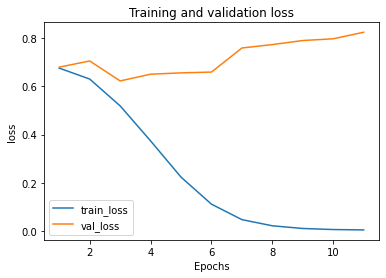

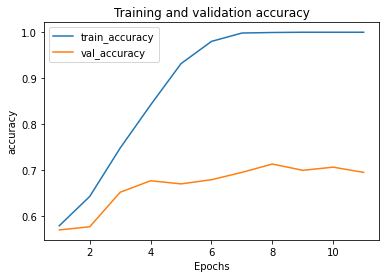

32/32 [==============================] - 8s 104ms/step - loss: 0.7744 - accuracy: 0.6790


In [8]:
import tensorflow as tf
tf.random.set_seed(50)
random.seed(50)
np.random.seed(50)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)
# train_folder = '/content/drive/MyDrive/Data/'
# all_label_2_images, labels = load_data_2(train_folder)
# x_train, y_train = prepare_x_y_according_to_description(all_label_2_images, '/content/drive/MyDrive/DL/Assignment_1/pairsDevTrain.txt')

model = OneShotModel()
parameters = {
    'batch_size' : 8 ,
    'validation_split' : 0.2 ,
    'epochs' : 20 ,
    'val_data' : None #(x_test, y_test)
}
h = model.fit(x_train, y_train, parameters)
model.plot_metric(h)
model.plot_metric(h, metric="accuracy")
score = model.evaluate(x_test, y_test)

In [9]:
model = tf.keras.models.load_model('model.h5')
model.fit(x_train,y_train,batch_size=8,epochs=3)
score = model.evaluate(x_test, y_test)

Epoch 1/3
275/275 [==============================] - 30s 105ms/step - loss: 0.2874 - accuracy: 0.8791
Epoch 2/3
275/275 [==============================] - 29s 105ms/step - loss: 0.0939 - accuracy: 0.9777
Epoch 3/3
32/32 [==============================] - 4s 103ms/step - loss: 0.6690 - accuracy: 0.7080


1/1 [==============================] - 0s 30ms/step - loss: 0.0387 - accuracy: 1.0000
1.0


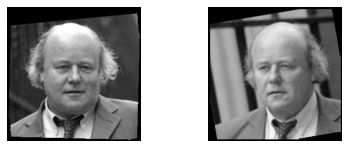

In [40]:
# same people /  correct
for i in range(100):
  sample_1 = np.array([x_test[0][i]])
  sample_2 = np.array([x_test[1][i]])
  y_test_sample = y_test[i]
  same_test_images = [sample_1, sample_2]
  result = model.evaluate(same_test_images,  np.array([y_test_sample]))
  if abs(y_test_sample - result[1]) < 1e-3 and y_test_sample == 1:
    print(result[1])
    break

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.axis('off')
    plt.imshow(same_test_images[i].reshape((250, 250)), cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()

1/1 [==============================] - 0s 26ms/step - loss: 1.1730 - accuracy: 0.0000e+00
0.0


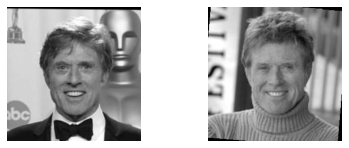

In [41]:
# same people / incorrect 
for i in range(100):
  sample_1 = np.array([x_test[0][i]])
  sample_2 = np.array([x_test[1][i]])
  y_test_sample = y_test[i]
  same_test_images = [sample_1, sample_2]
  result = model.evaluate(same_test_images,  np.array([y_test_sample]))
  if abs(y_test_sample - result[1]) > 1e-3 and y_test_sample == 1:
    print(result[1])
    break

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.axis('off')
    plt.imshow(same_test_images[i].reshape((250, 250)), cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()


1/1 [==============================] - 0s 30ms/step - loss: 0.9129 - accuracy: 0.0000e+00


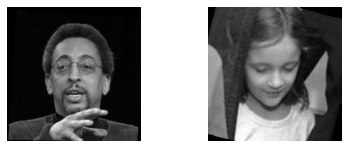

In [37]:
# deferent people /  correct
for i in range(100):
  sample_1 = np.array([x_test[0][i]])
  sample_2 = np.array([x_test[1][i]])
  y_test_sample = y_test[i]
  same_test_images = [sample_1, sample_2]
  result = model.evaluate(same_test_images,  np.array([y_test_sample]))
  if abs(y_test_sample - result[1]) < 1e-3 and y_test_sample == 0:
    print(result[1])
    break

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.axis('off')
    plt.imshow(same_test_images[i].reshape((250, 250)), cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()

1/1 [==============================] - 0s 24ms/step - loss: 0.0033 - accuracy: 1.0000
1.0


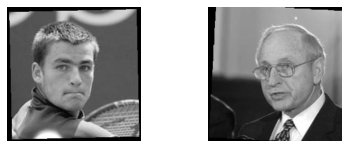

In [39]:
# deferent people /  incorrect
for i in range(100):
  sample_1 = np.array([x_test[0][i]])
  sample_2 = np.array([x_test[1][i]])
  y_test_sample = y_test[i]
  same_test_images = [sample_1, sample_2]
  result = model.evaluate(same_test_images,  np.array([y_test_sample]))
  if abs(y_test_sample - result[1]) > 1e-3 and y_test_sample == 0:
    print(result[1])
    break

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.axis('off')
    plt.imshow(same_test_images[i].reshape((250, 250)), cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()

In [14]:
# find indexes for in/correct predictions

for i in range(500, 520):
  sample_1 = np.array([x_test[0][i]])
  sample_2 = np.array([x_test[1][i]])
  y_sample =  np.array([1])
  same_test_images = [sample_1, sample_2]
  print("index ",i)
  result = model.evaluate(same_test_images, y_sample)

index  500
1/1 [==============================] - 0s 23ms/step - loss: 0.3544 - accuracy: 1.0000
index  501
1/1 [==============================] - 0s 27ms/step - loss: 0.0319 - accuracy: 1.0000
index  502
1/1 [==============================] - 0s 22ms/step - loss: 0.0563 - accuracy: 1.0000
index  503
1/1 [==============================] - 0s 22ms/step - loss: 0.1239 - accuracy: 1.0000
index  504
1/1 [==============================] - 0s 21ms/step - loss: 0.0341 - accuracy: 1.0000
index  505
1/1 [==============================] - 0s 21ms/step - loss: 0.0700 - accuracy: 1.0000
index  506
1/1 [==============================] - 0s 23ms/step - loss: 2.1685 - accuracy: 0.0000e+00
index  507
1/1 [==============================] - 0s 25ms/step - loss: 0.8541 - accuracy: 0.0000e+00
index  508
1/1 [==============================] - 0s 22ms/step - loss: 0.0729 - accuracy: 1.0000
index  509
1/1 [==============================] - 0s 22ms/step - loss: 0.0848 - accuracy: 1.0000
index  510
1/1 [======